In [2]:
#load libraries
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
import re
from collections import Counter

In [330]:
def read_text_file(filename):
    photon_E, total_yield, yield_error = [],[],[]
    
    copy_lines=[]
    with open(filename) as f:
        lines = f.readlines()

    for line in lines:
        split_line = line.split()
        copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1): #2nd line in the file is the first relevant one
        line = copy_lines[i]

        photon_E.append(float(line[0])) #strip element name and type of commas
        total_yield.append(float(line[1]))
        yield_error.append(float(line[2]))

    return([photon_E, total_yield, yield_error])

# function to read data from a text file:

In [331]:
#This function simply reads a BEAR output text file with data and outputs it as a bunch of lists
def read_file(filename):
    #just declaring a list for each column
    phot_E = [] #eV
    I_KB = [] # INSTR_1, Kiethley B: instrument 1 with sample + bias, current
    I_KA = [] # INSTR_2, Kiethley A, instrument 2 (monitor)
    I_KC=[]

    copy_lines = []
    with open (filename, "r", encoding='windows-1254') as myfile: #encoding change resolves an error coming from an extra \n at the end of files
        for l in myfile: #read lines until first occurence of this long line

            if "______________________________________________" in l:
                break
        for l in myfile: #read the file again until this appears
            if "______________________________________________" in l:
                break

        for l in myfile: #from then on, read all non-empty lines and split them on tab
            if l != "\n":
                line = l.strip() 
                line = re.split(r'\t+', line)
                copy_lines.append(line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1):
        line = copy_lines[i]

        phot_E.append(line[1])
        I_KB.append(line[4])
        I_KA.append(line[5])
        I_KC.append(line[6])

    #extracted values are still strings --> cast numbers to floats
    for i in range(0, len(phot_E)):
        phot_E[i] = float(phot_E[i])
        I_KB[i] = float(I_KB[i])
        I_KA[i] = float(I_KA[i])
        I_KC[i] = float(I_KC[i])
    
    return([phot_E, I_KB, I_KA, I_KC])

# Function to convert eV to nm

In [332]:
def convert_eV_to_nm(energy_eV_list):
    # a simple function that takes a list with photon energy values (in eV) and converts them into wavelength (in nm)
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J*1e9) #in nm
    return(wavelength_list)

# Function to convert nm to eV:

In [333]:
def convert_nm_to_eV(nm_list):
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    eV_list = []
    for lambda_val in nm_list:
        energy_J = h*c/(lambda_val*1e-9)
        energy_eV = energy_J/eV
        eV_list.append(energy_eV) #in nm
    return(np.array(eV_list))

# Function to extract region from a dataframe:

In [334]:
def get_region_df(reg_filename=str, reg_number=int, material_name=str):
    # function that takes a filename (textfile that should contain BEAR data with a single region), the region number and material name, and outputs a dataframe with the data
    reg = read_file(reg_filename) #call the readfile function (defined above) and store real time, photon energy, beamspot coordinates (x,y), and current readings (sample, monitor, BPM sum)
    #organize the data into the dataframe and return it
    reg_data = {'phot_E': reg[0], 'I_KB': reg[1], 'I_KA' : reg[2], 'I_KC': reg[3]}
    reg_df = pd.DataFrame(data=reg_data)
    reg_df['reg_number'] = reg_number
    reg_df['material_name'] = material_name

    #now the photon energy needs to be calibrated
    phot_E_exp = reg[1] #experimental photon energy
    phot_E_real = reg[1] #ignore calibration for now

    reg_df['phot_E_real'] = phot_E_real
    return(reg_df)

# August 2022 version of function to combine data from multiple regions into a single dataframe

In [335]:
def concate_regions_aug22(file_number=int, N_of_regs=int, material_name=str,reject_regions=list,add_regions_from_files=list):
    repetitions = []
    for i in range(len(add_regions_from_files)):
        val = add_regions_from_files[i]
        val_count_sofar = Counter(add_regions_from_files[:i+1])[val]
        repetitions.append(val_count_sofar)

    all_regions = []
    ind = 0
    for i in range(1,N_of_regs+1): #counting regions from 1, not from 0 (following how the files are written!)
        if i not in reject_regions: #if a respective index didn't saturate (aka the data's good)
            append_this = get_region_df(reg_filename=f"20220108_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",reg_number=i, material_name=material_name)
            all_regions.append(append_this) #append the dataframe to others
        else: #if a region did saturate (or shall be removed for some other reason)
            new_file_number = add_regions_from_files[ind]
            if new_file_number != 0: #if the new file is legit
                
                new_reg_ind = repetitions[ind] #substitute region numbering would start from 1 again
                append_this = get_region_df(reg_filename=f"20220108_arneodo/file(1)_Region {new_reg_ind}__" + "{:04d}".format(new_file_number) + ".txt",reg_number=i, material_name=material_name)
                all_regions.append(append_this) #append the dataframe to others
            ind += 1
    df = pd.concat(all_regions, ignore_index=True, sort=False) #combine all used regions
    return df

# Instrument 3 Dark readings (Keithley C)

Text(0, 0.5, 'dark photodiode (KC) current')

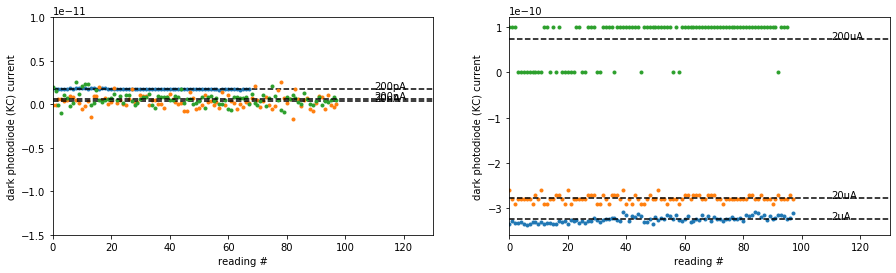

In [336]:
dark_200pA_df = get_region_df(reg_filename=f"20220108_arneodo/file(1)" + "{:04d}".format(21) + ".txt",reg_number=1, material_name='dark_200pA')
dark_20nA_df = get_region_df(reg_filename=f"20220108_arneodo/file(1)" + "{:04d}".format(22) + ".txt",reg_number=1, material_name='dark_20nA')
dark_200nA_df = get_region_df(reg_filename=f"20220108_arneodo/file(1)" + "{:04d}".format(24) + ".txt",reg_number=1, material_name='dark_200nA')
dark_2uA_df = get_region_df(reg_filename=f"20220108_arneodo/file(1)" + "{:04d}".format(25) + ".txt",reg_number=1, material_name='dark_2uA')
dark_20uA_df = get_region_df(reg_filename=f"20220108_arneodo/file(1)" + "{:04d}".format(26) + ".txt",reg_number=1, material_name='dark_20uA')
dark_200uA_df = get_region_df(reg_filename=f"20220108_arneodo/file(1)" + "{:04d}".format(27) + ".txt",reg_number=1, material_name='dark_200uA')

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(dark_200pA_df['I_KC'],'.')
KC_dark_200pA=np.mean(dark_200pA_df['I_KC'])
plt1.axhline(y=KC_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KC_dark_200pA)

plt1.plot(dark_20nA_df['I_KC'],'.')
KC_dark_20nA=np.mean(dark_20nA_df['I_KC'])
plt1.axhline(y=KC_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KC_dark_20nA)

plt1.plot(dark_200nA_df['I_KC'],'.')
KC_dark_200nA=np.mean(dark_200nA_df['I_KC'])
plt1.axhline(y=KC_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KC_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_ylim(-1.5e-11,1e-11)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark photodiode (KC) current')

plt2.plot(dark_2uA_df['I_KC'],'.')
KC_dark_2uA=np.mean(dark_2uA_df['I_KC'])
plt2.axhline(y=KC_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KC_dark_2uA)

plt2.plot(dark_20uA_df['I_KC'],'.')
KC_dark_20uA=np.mean(dark_20uA_df['I_KC'])
plt2.axhline(y=KC_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KC_dark_20uA)

plt2.plot(dark_200uA_df['I_KC'],'.')
KC_dark_200uA=np.mean(dark_200uA_df['I_KC'])
plt2.axhline(y=KC_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KC_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark photodiode (KC) current')


# Keithley A (monitor) Dark readings

Text(0, 0.5, 'dark monitor (KA) current')

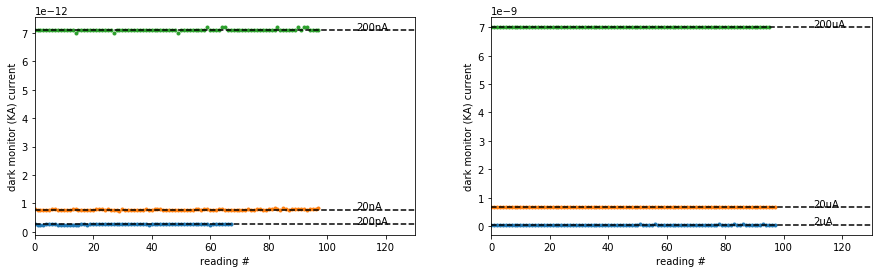

In [337]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(dark_200pA_df['I_KA'],'.')
KA_dark_200pA=np.mean(dark_200pA_df['I_KA'])
plt1.axhline(y=KA_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KA_dark_200pA)

plt1.plot(dark_20nA_df['I_KA'],'.')
KA_dark_20nA=np.mean(dark_20nA_df['I_KA'])
plt1.axhline(y=KA_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KA_dark_20nA)

plt1.plot(dark_200nA_df['I_KA'],'.')
KA_dark_200nA=np.mean(dark_200nA_df['I_KA'])
plt1.axhline(y=KA_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KA_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark monitor (KA) current')

plt2.plot(dark_2uA_df['I_KA'],'.')
KA_dark_2uA=np.mean(dark_2uA_df['I_KA'])
plt2.axhline(y=KA_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KA_dark_2uA)

plt2.plot(dark_20uA_df['I_KA'],'.')
KA_dark_20uA=np.mean(dark_20uA_df['I_KA'])
plt2.axhline(y=KA_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KA_dark_20uA)

plt2.plot(dark_200uA_df['I_KA'],'.')
KA_dark_200uA=np.mean(dark_200uA_df['I_KA'])
plt2.axhline(y=KA_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KA_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark monitor (KA) current')

# Keithley B (sample) Dark readings

Text(0, 0.5, 'dark sample (KB) current')

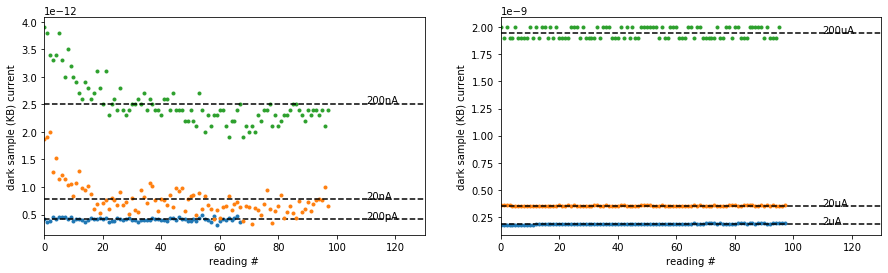

In [338]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(dark_200pA_df['I_KB'],'.')
KB_dark_200pA=np.mean(dark_200pA_df['I_KB'])
plt1.axhline(y=KB_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KB_dark_200pA)

plt1.plot(dark_20nA_df['I_KB'],'.')
KB_dark_20nA=np.mean(dark_20nA_df['I_KB'])
plt1.axhline(y=KB_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KB_dark_20nA)

plt1.plot(dark_200nA_df['I_KB'],'.')
KB_dark_200nA=np.mean(dark_200nA_df['I_KB'])
plt1.axhline(y=KB_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KB_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark sample (KB) current')

plt2.plot(dark_2uA_df['I_KB'],'.')
KB_dark_2uA=np.mean(dark_2uA_df['I_KB'])
plt2.axhline(y=KB_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KB_dark_2uA)

plt2.plot(dark_20uA_df['I_KB'],'.')
KB_dark_20uA=np.mean(dark_20uA_df['I_KB'])
plt2.axhline(y=KB_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KB_dark_20uA)

plt2.plot(dark_200uA_df['I_KB'],'.')
KB_dark_200uA=np.mean(dark_200uA_df['I_KB'])
plt2.axhline(y=KB_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KB_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark sample (KB) current')

# Summary of recorded (dark) current offsets:

In [339]:
offsets_data = {'range': ["200pA",'20nA','200nA','2uA','20uA','200uA'], 'KA_offset': [KA_dark_200pA,KA_dark_20nA,KA_dark_200nA,KA_dark_2uA,KA_dark_20uA,KA_dark_200uA], 'KB_offset' : [KB_dark_200pA,KB_dark_20nA,KB_dark_200nA,KB_dark_2uA,KB_dark_20uA,KB_dark_200uA], 'KC_offset': [KC_dark_200pA,KC_dark_20nA,KC_dark_200nA,KC_dark_2uA,KC_dark_20uA,KC_dark_200uA]}
offsets_df = pd.DataFrame(data=offsets_data)
offsets_df

,range,KA_offset,KB_offset,KC_offset
0,200pA,2.642912e-13,4.132412e-13,1.773707e-12
1,20nA,7.802041e-13,7.826531e-13,3.582653e-13
2,200nA,7.104082e-12,2.514286e-12,5.969388e-13
3,2uA,5.304082e-11,1.851224e-10,-3.247347e-10
4,20uA,6.848980e-10,3.531633e-10,-2.781633e-10
5,200uA,7.000000e-09,1.947917e-09,7.395833e-11


# Function to subtract dark offsets from each dataframe:

In [340]:
def subtract_offsets(df_sample,sensvals,df_offsets):
    length = len(df_sample['phot_E'])
    df_sample['KA_offset'] = np.zeros(length)
    df_sample['KB_offset'] = np.zeros(length)
    df_sample['KC_offset'] = np.zeros(length)

    df_copy = df_sample # I iterate over original dataframe but I write into its copy
    for i in range(len(df_sample)): #iterate over the rows of sample dataframe
        row = df_sample.iloc[[i]] #copy a single row
        reg_number = int(row['reg_number'].tolist()[0])

        if '200pA' in sensvals[reg_number-1][0]: #ASSIGNING KA RANGE
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[0]['KA_offset']
        elif '20nA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[1]['KA_offset']
        elif '200nA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[2]['KA_offset']
        elif '2uA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[3]['KA_offset']
        elif '20uA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[4]['KA_offset']
        elif '200uA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[5]['KA_offset']
        else: print("KA range not found!")

        if '200pA' in sensvals[reg_number-1][1]: #ASSIGNING KB RANGE
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[0]['KB_offset']
        elif '20nA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[1]['KB_offset']
        elif '200nA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[2]['KB_offset']
        elif '2uA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[3]['KB_offset']
        elif '20uA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[4]['KB_offset']
        elif '200uA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[5]['KB_offset']
        else: print("KB range not found!")

        if '200pA' in sensvals[reg_number-1][2]: #ASSIGNING KC RANGE
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[0]['KC_offset']
        elif '20nA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[1]['KC_offset']
        elif '200nA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[2]['KC_offset']
        elif '2uA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[3]['KC_offset']
        elif '20uA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[4]['KC_offset']
        elif '200uA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[5]['KC_offset']
        else: print("KC range not found!")

    df_sample = df_copy
    df_sample['I_KA_real'] = df_sample['I_KA'] - df_sample['KA_offset']
    df_sample['I_KB_real'] = df_sample['I_KB'] - df_sample['KB_offset']
    df_sample['I_KC_real'] = df_sample['I_KC'] - df_sample['KC_offset']

    return

# Plot and polyfit of the Photodiode's responsivity function (MARCH/August 2022):

/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(350, 1500)

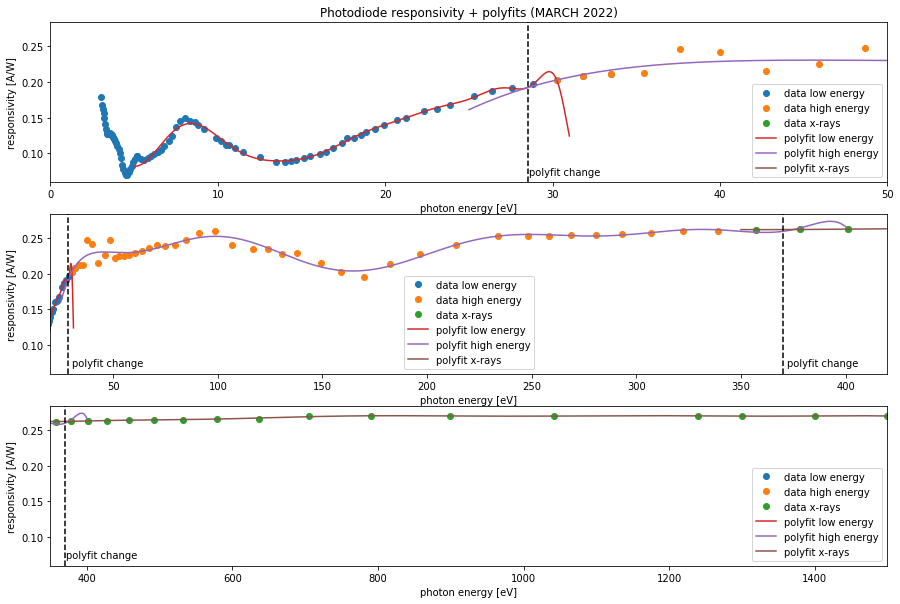

In [341]:
ph_eV, wavelength_nm, responsivity = [],[],[] # load photodiode responsivity from a textfile:

filename = "axuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

for i in range(startline-1,len(copy_lines)-1): #from each line, extract a name/number and append it into its relevant column
    line = copy_lines[i]
    ph_eV.append(float(line[0]))
    wavelength_nm.append(float(line[1]))
    responsivity.append(float(line[3]))

pd_data = {'phot_E': ph_eV, 'wavelength': wavelength_nm, 'responsivity' : responsivity}
responsivity_df_march = pd.DataFrame(data=pd_data).sort_values('phot_E')
cond1 = responsivity_df_march['phot_E'] <= 35
cond2 = responsivity_df_march['phot_E'] > 3
cond3 = responsivity_df_march['phot_E'] > 30
cond4 = responsivity_df_march['phot_E'] <= 420
cond5 = responsivity_df_march['phot_E'] > 350
energy_eV_march_low = responsivity_df_march[cond1 & cond2]['phot_E'].tolist()
energy_eV_march_high = responsivity_df_march[cond3 & cond4]['phot_E'].tolist()
energy_eV_march_xray = responsivity_df_march[cond5]['phot_E'].tolist()
responsivity_march_low = responsivity_df_march[cond1 & cond2]['responsivity'].tolist()
responsivity_march_high = responsivity_df_march[cond3 & cond4]['responsivity'].tolist()
responsivity_march_xray = responsivity_df_march[cond5]['responsivity'].tolist()

responsivity_fit_march_low = np.poly1d(np.polyfit(energy_eV_march_low, responsivity_march_low, 25)) #make a polynomial fit for the first region
responsivity_fit_march_high = np.poly1d(np.polyfit(energy_eV_march_high, responsivity_march_high, 10)) #make a polynomial fit for the first region
responsivity_fit_march_xray = np.poly1d(np.polyfit(energy_eV_march_xray, responsivity_march_xray, 10)) #make a polynomial fit for the first region

test_eV_low = np.linspace(5,31,1000)
test_eV_high = np.linspace(25,400,10000)
test_eV_xray = np.linspace(350,1500,10000)

thresh_1_march = 28.5 #photon energies (thresholds) at which polyfit needs to be changed
thresh_2_march = 370

fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(15,10))

plt1.set_xlabel('photon energy [eV]')
plt1.set_ylabel('responsivity [A/W]')
plt1.set_title('Photodiode responsivity + polyfits (MARCH 2022)')
plt1.plot(energy_eV_march_low,responsivity_march_low,'o',label='data low energy')
plt1.plot(energy_eV_march_high,responsivity_march_high,'o',label='data high energy')
plt1.plot(energy_eV_march_xray,responsivity_march_xray,'o',label='data x-rays')
plt1.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',label='polyfit low energy')
plt1.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',label='polyfit high energy')
plt1.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',label='polyfit x-rays')
plt1.axvline(x=thresh_1_march,linestyle='--',color='black')
plt1.text(s='polyfit change',x=thresh_1_march+0.1,y=0.07)
plt1.legend()
plt1.set_xlim(0,50)

plt2.set_xlabel('photon energy [eV]')
plt2.set_ylabel('responsivity [A/W]')
plt2.plot(energy_eV_march_low,responsivity_march_low,'o',label='data low energy')
plt2.plot(energy_eV_march_high,responsivity_march_high,'o',label='data high energy')
plt2.plot(energy_eV_march_xray,responsivity_march_xray,'o',label='data x-rays')
plt2.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',label='polyfit low energy')
plt2.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',label='polyfit high energy')
plt2.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',label='polyfit x-rays')
plt2.axvline(x=thresh_1_march,linestyle='--',color='black')
plt2.axvline(x=thresh_2_march,linestyle='--',color='black')
plt2.text(s='polyfit change',x=thresh_1_march+2,y=0.07)
plt2.text(s='polyfit change',x=thresh_2_march+2,y=0.07)
plt2.legend()
plt2.set_xlim(20,420)

plt3.set_xlabel('photon energy [eV]')
plt3.set_ylabel('responsivity [A/W]')
plt3.plot(energy_eV_march_low,responsivity_march_low,'o',label='data low energy')
plt3.plot(energy_eV_march_high,responsivity_march_high,'o',label='data high energy')
plt3.plot(energy_eV_march_xray,responsivity_march_xray,'o',label='data x-rays')
plt3.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',label='polyfit low energy')
plt3.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',label='polyfit high energy')
plt3.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',label='polyfit x-rays')
plt3.axvline(x=thresh_1_march,linestyle='--',color='black')
plt3.axvline(x=thresh_2_march,linestyle='--',color='black')
plt3.text(s='polyfit change',x=thresh_2_march+2,y=0.07)
plt3.legend()
plt3.set_xlim(350,1500)

# Plot and polyfit of the Photodiode's responsivity function (AUGUST 2021):

/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


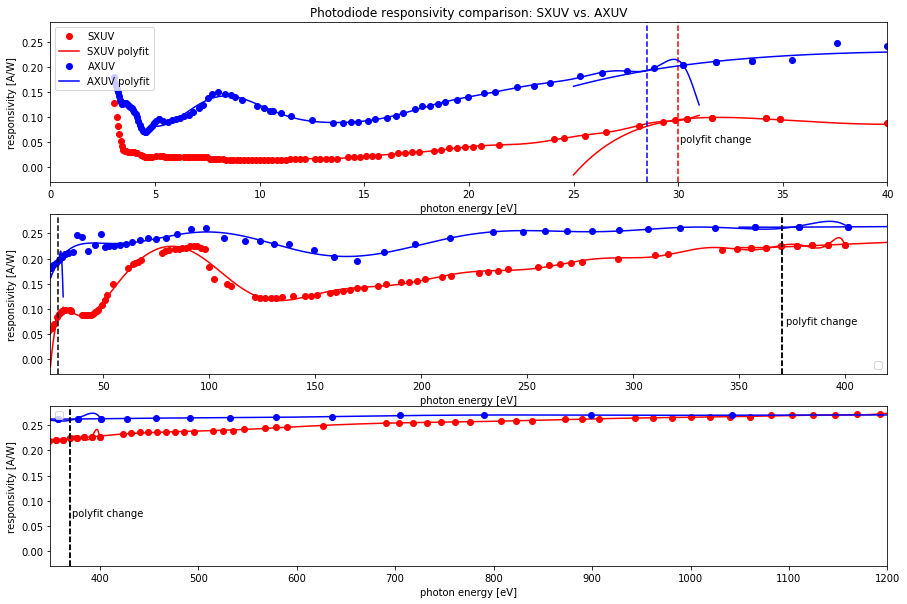

In [472]:
# load photodiode responsivity from a textfile:
lambda_nm, responsivity = [],[] #responsivity in Amperes per Watt!

filename = "sxuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
for i in range(startline-1,len(copy_lines)-1):
    line = copy_lines[i]

    lambda_nm.append(float(line[0]))
    responsivity.append(float(line[1]))


pd_data = {'phot_E': convert_nm_to_eV(lambda_nm), 'wavelength': lambda_nm, 'responsivity' : responsivity}
responsivity_df_aug = pd.DataFrame(data=pd_data).sort_values('phot_E')

cond1 = responsivity_df_aug['phot_E'] <= 35
cond2 = responsivity_df_aug['phot_E'] > 3
cond3 = responsivity_df_aug['phot_E'] > 30
cond4 = responsivity_df_aug['phot_E'] <= 420
cond5 = responsivity_df_aug['phot_E'] > 350
cond6 = responsivity_df_aug['phot_E'] < 1200
energy_eV_aug_low = responsivity_df_aug[cond1 & cond2]['phot_E'].tolist()
energy_eV_aug_high = responsivity_df_aug[cond3 & cond4]['phot_E'].tolist()
energy_eV_aug_xray = responsivity_df_aug[cond5 & cond6]['phot_E'].tolist()
responsivity_aug_low = responsivity_df_aug[cond1 & cond2]['responsivity'].tolist()
responsivity_aug_high = responsivity_df_aug[cond3 & cond4]['responsivity'].tolist()
responsivity_aug_xray = responsivity_df_aug[cond5 & cond6]['responsivity'].tolist()

responsivity_fit_aug_low = np.poly1d(np.polyfit(energy_eV_aug_low, responsivity_aug_low, 25)) #make a polynomial fit for the first region
responsivity_fit_aug_high = np.poly1d(np.polyfit(energy_eV_aug_high, responsivity_aug_high, 20)) #make a polynomial fit for the first region
responsivity_fit_aug_xray = np.poly1d(np.polyfit(energy_eV_aug_xray, responsivity_aug_xray, 10)) #make a polynomial fit for the first region

test_eV_low = np.linspace(5,31,1000)
test_eV_high = np.linspace(25,400,10000)
test_eV_xray = np.linspace(350,1200,10000)

thresh_1_aug = 30 #photon energies (thresholds) at which polyfit needs to be changed
thresh_2_aug = 370

fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(15,10))

col1 = 'red'
col2 = 'blue'

plt1.set_xlabel('photon energy [eV]')
plt1.set_ylabel('responsivity [A/W]')
plt1.set_title('Photodiode responsivity comparison: SXUV vs. AXUV')
plt1.plot(energy_eV_aug_low,responsivity_aug_low,'o',color=col1,label='SXUV')
plt1.plot(energy_eV_aug_high,responsivity_aug_high,'o',color=col1)
plt1.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',color=col1)
plt1.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',color=col1,label='SXUV polyfit')
plt1.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',color=col1)
plt1.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',color=col1)
plt1.axvline(x=thresh_1_aug,linestyle='--',color=col1)
plt1.text(s='polyfit change',x=thresh_1_aug+0.1,y=0.05)

plt1.plot(energy_eV_march_low,responsivity_march_low,'o',color=col2,label='AXUV')
plt1.plot(energy_eV_march_high,responsivity_march_high,'o',color=col2)
plt1.plot(energy_eV_march_xray,responsivity_march_xray,'o',color=col2)
plt1.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',color=col2,label='AXUV polyfit')
plt1.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',color=col2)
plt1.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',color=col2)
plt1.axvline(x=thresh_1_march,linestyle='--',color=col2)

plt1.legend()
plt1.set_xlim(0,40)

plt2.set_xlabel('photon energy [eV]')
plt2.set_ylabel('responsivity [A/W]')
plt2.plot(energy_eV_aug_low,responsivity_aug_low,'o',color=col1)
plt2.plot(energy_eV_aug_high,responsivity_aug_high,'o',color=col1)
plt2.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',color=col1)
plt2.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',color=col1)
plt2.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',color=col1)
plt2.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',color=col1)
plt2.axvline(x=thresh_2_aug,linestyle='--',color='black')
plt2.text(s='polyfit change',x=thresh_2_aug+2,y=0.07)

plt2.plot(energy_eV_march_low,responsivity_march_low,'o',color=col2)
plt2.plot(energy_eV_march_high,responsivity_march_high,'o',color=col2)
plt2.plot(energy_eV_march_xray,responsivity_march_xray,'o',color=col2)
plt2.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',color=col2)
plt2.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',color=col2)
plt2.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',color=col2)
plt2.axvline(x=thresh_1_march,linestyle='--',color='black')
plt2.axvline(x=thresh_2_march,linestyle='--',color='black')
plt2.legend()
plt2.set_xlim(25,420)

plt3.set_xlabel('photon energy [eV]')
plt3.set_ylabel('responsivity [A/W]')
plt3.plot(energy_eV_aug_low,responsivity_aug_low,'o',color=col1)
plt3.plot(energy_eV_aug_high,responsivity_aug_high,'o',color=col1)
plt3.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',color=col1)
plt3.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',color=col1)
plt3.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',color=col1)
plt3.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',color=col1)
plt3.axvline(x=thresh_1_aug,linestyle='--',color='black')
plt3.axvline(x=thresh_2_aug,linestyle='--',color='black')
plt3.text(s='polyfit change',x=thresh_2_aug+2,y=0.07)

plt3.plot(energy_eV_march_low,responsivity_march_low,'o',color=col2)
plt3.plot(energy_eV_march_high,responsivity_march_high,'o',color=col2)
plt3.plot(energy_eV_march_xray,responsivity_march_xray,'o',color=col2)
plt3.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',color=col2)
plt3.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',color=col2)
plt3.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',color=col2)
plt3.axvline(x=thresh_1_march,linestyle='--',color='black')
plt3.axvline(x=thresh_2_march,linestyle='--',color='black')

plt3.legend()
plt3.set_xlim(350,1200)
plt.savefig('plots/responsivity_comparisons.png', dpi=300)

# Comparison of photodiode responsivities:

(350, 1200)

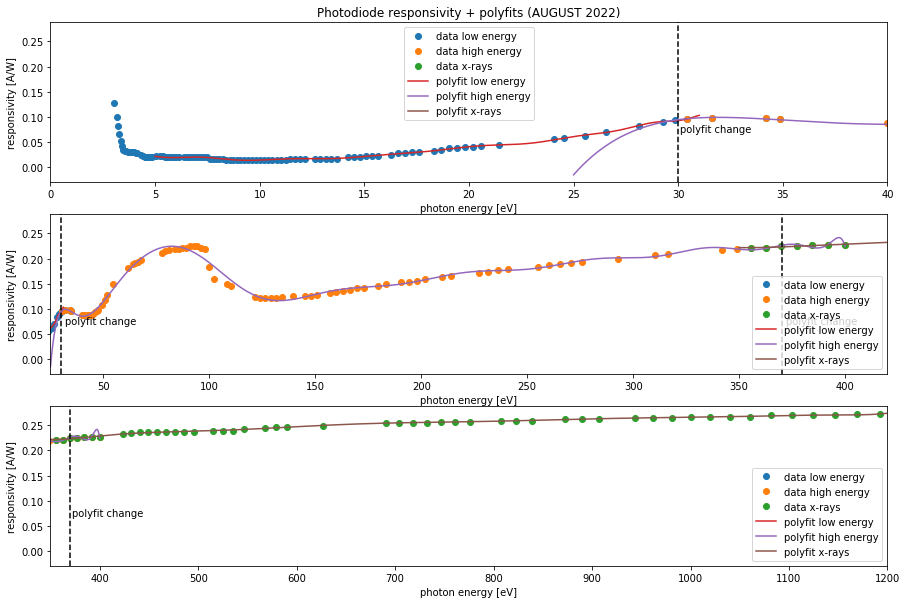

In [446]:
fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(15,10))

plt1.set_xlabel('photon energy [eV]')
plt1.set_ylabel('responsivity [A/W]')
plt1.set_title('Photodiode responsivity (and its polyfit) comparison: AXUV vs. SXUV')
plt1.plot(energy_eV_aug_low,responsivity_aug_low,'o',label='data low energy')
plt1.plot(energy_eV_aug_high,responsivity_aug_high,'o',label='data high energy')
plt1.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',label='data x-rays')
plt1.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',label='polyfit low energy')
plt1.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',label='polyfit high energy')
plt1.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',label='polyfit x-rays')
plt1.axvline(x=thresh_1_aug,linestyle='--',color='black')
plt1.text(s='polyfit change',x=thresh_1_aug+0.1,y=0.07)
plt1.legend()
plt1.set_xlim(0,40)

plt2.set_xlabel('photon energy [eV]')
plt2.set_ylabel('responsivity [A/W]')
plt2.plot(energy_eV_aug_low,responsivity_aug_low,'o',label='data low energy')
plt2.plot(energy_eV_aug_high,responsivity_aug_high,'o',label='data high energy')
plt2.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',label='data x-rays')
plt2.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',label='polyfit low energy')
plt2.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',label='polyfit high energy')
plt2.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',label='polyfit x-rays')
plt2.axvline(x=thresh_1_aug,linestyle='--',color='black')
plt2.axvline(x=thresh_2_aug,linestyle='--',color='black')
plt2.text(s='polyfit change',x=thresh_1_aug+2,y=0.07)
plt2.text(s='polyfit change',x=thresh_2_aug+2,y=0.07)
plt2.legend()
plt2.set_xlim(25,420)

plt3.set_xlabel('photon energy [eV]')
plt3.set_ylabel('responsivity [A/W]')
plt3.plot(energy_eV_aug_low,responsivity_aug_low,'o',label='data low energy')
plt3.plot(energy_eV_aug_high,responsivity_aug_high,'o',label='data high energy')
plt3.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',label='data x-rays')
plt3.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',label='polyfit low energy')
plt3.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',label='polyfit high energy')
plt3.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',label='polyfit x-rays')
plt3.axvline(x=thresh_1_aug,linestyle='--',color='black')
plt3.axvline(x=thresh_2_aug,linestyle='--',color='black')
plt3.text(s='polyfit change',x=thresh_2_aug+2,y=0.07)
plt3.legend()
plt3.set_xlim(350,1200)

# A function to compute the photoelectric YIELD:

In [343]:
def compute_yield(mat_df=object,PD_df=object,threshs_aug=list,threshs_march=list,pd_version=str,subtract_offset=bool):

    thresh_1_aug = threshs_aug[0]
    thresh_2_aug = threshs_aug[1]
    thresh_1_march = threshs_march[0]
    thresh_2_march = threshs_march[1]

    mat_phot_E = np.array(mat_df['phot_E'].tolist())
    PD_phot_E  = np.array(PD_df['phot_E'].tolist())

    if subtract_offset:
        mat_I = np.array(mat_df['I_KB_real'].tolist())
        PD_I  = np.array(PD_df[ 'I_KC_real'].tolist())

        mat_I_monit = np.array(mat_df['I_KA_real'].tolist())
        PD_I_monit  = np.array(PD_df[ 'I_KA_real'].tolist())
    else:
        mat_I = np.array(mat_df['I_KB'].tolist())
        PD_I  = np.array(PD_df[ 'I_KC'].tolist())

        mat_I_monit = np.array(mat_df['I_KA'].tolist())
        PD_I_monit  = np.array(PD_df[ 'I_KA'].tolist())

    print("material df: ",len(mat_phot_E),'\nphotodiode df:',len(PD_phot_E))


    length = min(len(mat_phot_E),len(PD_phot_E))

    #now I need to split the responsivity factor into two since I'm using two different polyfits of the photodiode responsivity
    R = []
    for i in range(length):
        if "march" in pd_version:
            if mat_phot_E[i] <= thresh_1_march:
                R.append(responsivity_fit_march_low(mat_phot_E[i]))
            elif (mat_phot_E[i] > thresh_1_march) and (mat_phot_E[i] < thresh_2_march):
                R.append(responsivity_fit_march_high(mat_phot_E[i]))
            elif mat_phot_E[i] >= thresh_2_march:
                R.append(responsivity_fit_march_xray(mat_phot_E[i]))
                

        elif "aug" in pd_version:
            if mat_phot_E[i] <= thresh_1_aug:
                R.append(responsivity_fit_aug_low(mat_phot_E[i]))
            elif (mat_phot_E[i] > thresh_1_aug) and (mat_phot_E[i] < thresh_2_aug):
                R.append(responsivity_fit_aug_high(mat_phot_E[i]))
            elif mat_phot_E[i] >= thresh_2_aug:
                R.append(responsivity_fit_aug_xray(mat_phot_E[i]))
        else:
            print("incorrect photodiode data")

    R = np.array(R)

    TEY = (mat_I[:length]/mat_I_monit[:length]) * (PD_I_monit[:length]/PD_I[:length]) * R[:length] * PD_phot_E[:length]
    
    TEY=list(TEY)
    while len(TEY) != len(mat_df):
        TEY.append(0)
    TEY=np.array(TEY)
    
    mat_df['Yield'] = 0
    mat_df['Yield'] = TEY
    return

# Function to compute yield ERROR

In [344]:
def yield_error(mat_df=object,pd_df=object,threshs_aug=list,threshs_march=list,pd_version=str):

    l = min(len(mat_df),len(pd_df))
    P = 0.05

    I_s = np.array(mat_df['I_KB'].tolist())[:l] #sample current
    I_m1 = np.array(mat_df['I_KA'].tolist())[:l] # monitor current while sample in
    I_m2 = np.array(pd_df['I_KA'].tolist())[:l] #monitor current while photodiode in
    I_p = np.array(pd_df['I_KC'].tolist())[:l] # photodiode current
    E = np.array(pd_df['phot_E'].tolist())[:l] # photon energy

    DI_s = P*I_s #np.array(mat_df['KB_offset'].tolist()) #Delta sample current (absolute)
    DI_m1 = P*I_m1 #np.array(mat_df['KA_offset'].tolist()) #Delta monitor current while sample in
    DI_m2 = P*I_m2 #np.array(pd_df['KA_offset'].tolist()) # Delta monitor current while photodiode in
    DI_p = P*I_p #np.array(pd_df['KC_offset'].tolist()) # Delta photodiode current
    DE = E[:l]/100

    thresh_1_aug = threshs_aug[0]
    thresh_2_aug = threshs_aug[1]
    thresh_1_march = threshs_march[0]
    thresh_2_march = threshs_march[1]
    R = []
    for i in range(len(E)):
        if "march" in pd_version:
            if E[i] <= thresh_1_march:
                R.append(responsivity_fit_march_low(E[i]))
            elif (E[i] > thresh_1_march) and (E[i] < thresh_2_march):
                R.append(responsivity_fit_march_high(E[i]))
            elif E[i] >= thresh_2_march:
                R.append(responsivity_fit_march_xray(E[i]))
                

        elif "aug" in pd_version:
            if E[i] <= thresh_1_aug:
                R.append(responsivity_fit_aug_low(E[i]))
            elif (E[i] > thresh_1_aug) and (E[i] < thresh_2_aug):
                R.append(responsivity_fit_aug_high(E[i]))
            elif E[i] >= thresh_2_aug:
                R.append(responsivity_fit_aug_xray(E[i]))
        else:
            print("incorrect photodiode data")
    R = np.array(R)

    DR = P*R

    dYdI_s = I_m2/(I_m1*I_p)*E *R
    dYdI_m1 = I_s*I_m2/I_p*(1/I_m1)**2 *E *R
    dYdI_m2 = I_s/(I_m1*I_p)*E *R
    dYdI_p = I_s*I_m2/I_m1*(1/I_p)**2*E *R
    dYdR = I_s*I_m2/(I_m1*I_p)*E
    dYdE = I_s*I_m2/(I_m1*I_p)*R

    DY = np.sqrt((dYdI_s*DI_s)**2+(dYdI_m1*DI_m1)**2+(dYdI_m2*DI_m2)**2+(dYdI_p*DI_p)**2+(dYdR*DR)**2+(dYdE*DE)**2)

    DY=list(DY)
    while len(DY) != len(mat_df):
        DY.append(0)
    DY=np.array(DY)

    mat_df['yield_err'] = 0
    mat_df['yield_err'] = DY
    return

# Photodiode low, AUG 2022

,phot_E,I_KB,I_KA,I_KC,reg_number,material_name,phot_E_real,KA_offset,KB_offset,KC_offset,I_KA_real,I_KB_real,I_KC_real
0,3.099993,4.219000e-13,2.660000e-13,-1.660000e-10,1,PD_low_fine,4.219000e-13,2.642912e-13,4.132412e-13,-3.247347e-10,1.708824e-15,8.658824e-15,1.587347e-10
1,3.199996,4.518000e-13,2.556000e-13,-1.700000e-10,1,PD_low_fine,4.518000e-13,2.642912e-13,4.132412e-13,-3.247347e-10,-8.691176e-15,3.855882e-14,1.547347e-10
2,3.300002,4.231000e-13,2.577000e-13,-1.750000e-10,1,PD_low_fine,4.231000e-13,2.642912e-13,4.132412e-13,-3.247347e-10,-6.591176e-15,9.858824e-15,1.497347e-10
3,3.400001,3.677000e-13,2.552000e-13,-1.700000e-10,1,PD_low_fine,3.677000e-13,2.642912e-13,4.132412e-13,-3.247347e-10,-9.091176e-15,-4.554118e-14,1.547347e-10
4,3.499991,4.072000e-13,2.732000e-13,-1.670000e-10,1,PD_low_fine,4.072000e-13,2.642912e-13,4.132412e-13,-3.247347e-10,8.908824e-15,-6.041176e-15,1.577347e-10


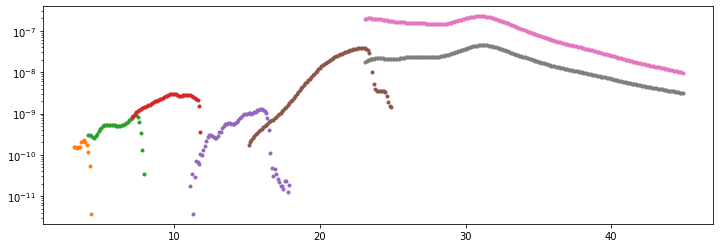

In [371]:
PD_low_file_number = 17
PD_low_N_of_regs = 7
PD_low_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_low_add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
                          #KA      KB     KC
PD_low_fine_sensvals = [['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['20nA' ,'20nA' ,'2uA'],
                        ['20nA' ,'20nA' ,'2uA'],
                        ['20nA' ,'20nA' ,'2uA']]

PD_low_df = concate_regions_aug22(file_number=PD_low_file_number,N_of_regs=PD_low_N_of_regs,material_name="PD_low_fine",reject_regions=PD_low_reject_regs,add_regions_from_files=PD_low_add_regs_from_files)
subtract_offsets(PD_low_df,PD_low_fine_sensvals,offsets_df)

figure(figsize=(12, 4))
for i in range(12):
    criterion = PD_low_df['reg_number'] == i
    pd_df = PD_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KC_real'],'.')
plt.yscale('log')

PD_low_df.head()

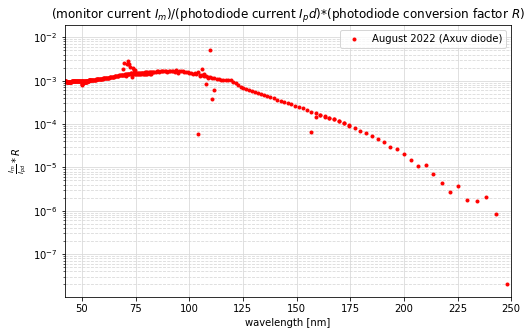

In [445]:
figure(figsize=(8, 5))

lines = ['photon_energy_eV    value   empty'] #data will be written into a file in this format
for i in range(7):
    criterion = PD_low_df['reg_number'] == i
    pd_df_aug = PD_low_df.loc[criterion]
    ph_E = np.array(pd_df_aug['phot_E'].tolist())
    I_KC = np.array(pd_df_aug['I_KC_real'].tolist()) #back in August, we measured photodiode current on KB, not KC
    I_KA = np.array(pd_df_aug['I_KA_real'].tolist())
    if i ==1: 
        plt.plot(convert_eV_to_nm(ph_E),I_KA/I_KC*responsivity_fit_march_low(ph_E),'.',color='red',label='August 2022 (Axuv diode)')
    else:
        plt.plot(convert_eV_to_nm(ph_E),I_KA/I_KC*responsivity_fit_march_low(ph_E),'.',color='red')

    for j in range(len(ph_E)):
        line = str(convert_eV_to_nm([ph_E[j]])[0]) + ' ' + str(I_KA[j]/I_KC[j]*responsivity_fit_march_low(ph_E[j])) + ' ' + str(0)
        lines.append(line)
with open('other_txt_files/aug22_photodiode_test.txt', 'w') as f:
    f.write('\n'.join(lines))

plt.yscale('log')
plt.xlabel('wavelength [nm]')
plt.title(r'(monitor current $I_m$)/(photodiode current $I_pd$)*(photodiode conversion factor $R$)')
plt.ylabel(r'$\frac{I_{m}}{I_{pd}} * R$')
plt.xlim(42,250)
#plt.ylim(0,0.004)
plt.grid(which = 'major', linestyle='-',color='0.85')
plt.grid(which = 'minor', linestyle='--', color='0.85')
plt.legend(loc='upper right')
#plt.savefig('plots/photodiode_comparisons.png', dpi=300)

# Photodiode HIGH (40-1500 eV) + plotting all photodiode current:

Text(0, 0.5, 'diode current [A]')

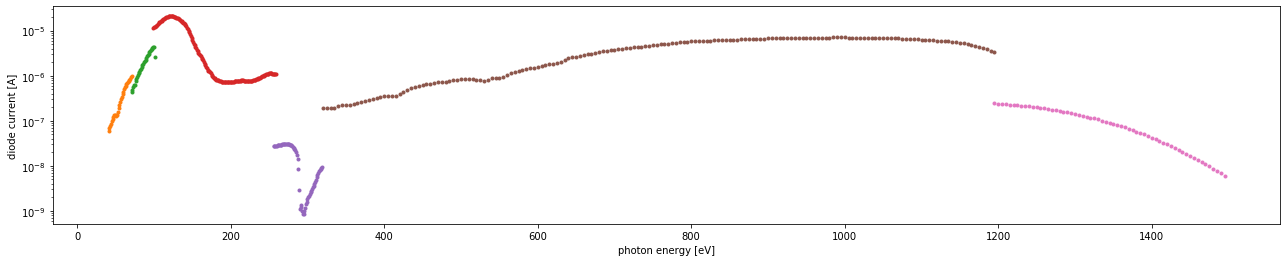

In [346]:
PD_high_file_number = 19
PD_high_N_of_regs = 6
PD_high_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_high_add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
PD_high_sensvals = [['20nA' ,'20nA' ,'2uA'],
                    ['20nA' ,'200nA','20uA'],
                    ['200nA','200nA','20uA'],
                    ['200nA','200pA','2uA'],
                    ['200nA','20nA' ,'20uA'],
                    ['200nA','200pA','2uA']]

PD_high_df = concate_regions_aug22(file_number=PD_high_file_number,N_of_regs=PD_high_N_of_regs,material_name='PD_high',reject_regions=PD_high_reject_regs,add_regions_from_files=PD_high_add_regs_from_files)
subtract_offsets(PD_high_df,PD_high_sensvals,offsets_df)

figure(figsize=(22, 4))
for i in range(12):
    criterion = PD_high_df['reg_number'] == i
    pd_df = PD_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KC_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Silver:

Text(0.5, 1.0, 'Silver current: August 2022')

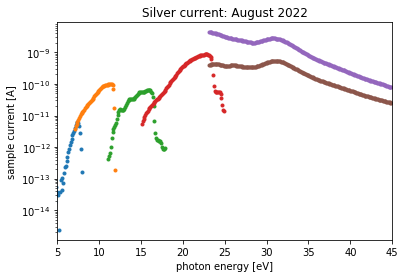

In [347]:
mat_name = 'Silver_low'
mat_file_number = 15
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
Gold_low_sensvals =[['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['20nA' ,'20nA' ,'2uA'],
                    ['20nA' ,'20nA' ,'2uA'],
                    ['20nA' ,'20nA' ,'2uA']]

Silver_low_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Silver_low_df,Gold_low_sensvals,offsets_df)

for i in range(2,8):
    criterion = Silver_low_df['reg_number'] == i
    pd_df = Silver_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')
plt.xlim(5,45)
plt.title('Silver current: August 2022')
#plt.savefig('plots/Ag_current_Aug22.png', dpi=300)

In [348]:
compute_yield(mat_df=Silver_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=Silver_low_df,pd_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')


material df:  708 
photodiode df: 708


In [349]:
mat_name = 'Silver_high'
mat_file_number = 11
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves! (in order!)
add_regs_from_files = [0] #number of files from which each respective saturated region shall be substituted from (set 0 if it's supposed to stay empty)
Silver_high_sensvals=[['20nA' ,'20nA' ,'2uA'],
                    ['20nA' ,'200nA','2uA'],
                    ['200nA','200nA','20uA'],
                    ['200nA','200pA','2uA'],
                    ['200nA','20nA' ,'2uA'],
                    ['200nA','200pA','2uA']]


Silver_high_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Silver_high_df,Silver_high_sensvals,offsets_df)
compute_yield(mat_df=Silver_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=Silver_high_df,pd_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')


material df:  524 
photodiode df: 524


(0, 247.9953544858527)

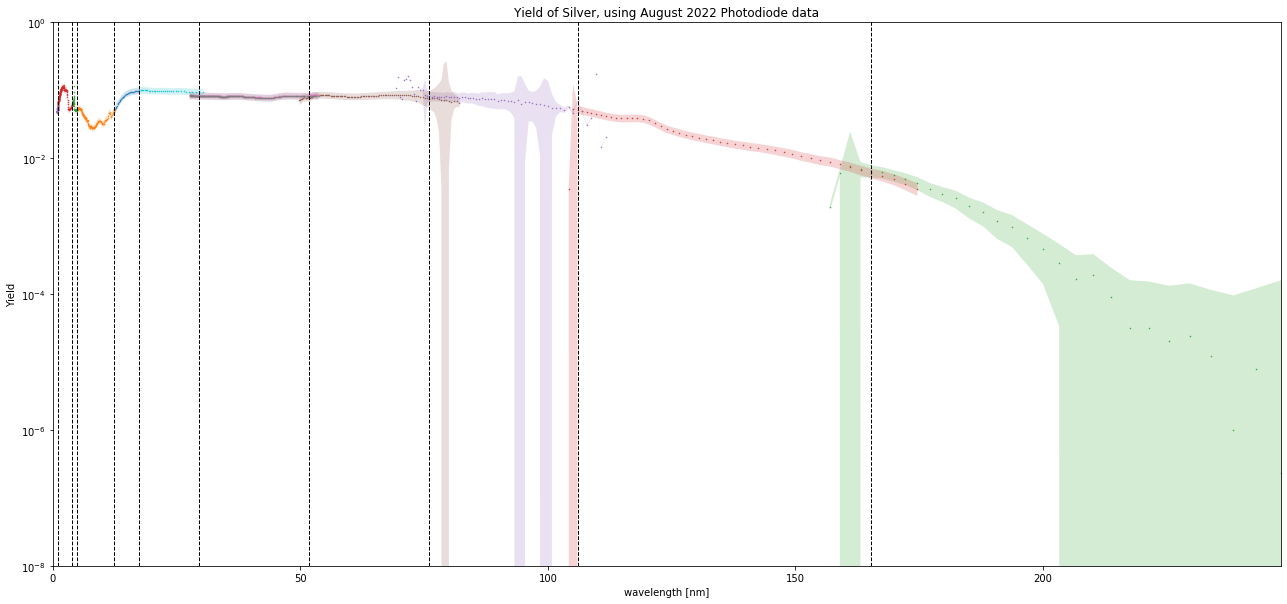

In [350]:
figure(figsize=(22, 10))
lines = ['photon_energy_eV    total_yield    yield_error'] #data will be written into a file in this format
alpha=0.2

for i in range(8):
    criterion = Silver_low_df['reg_number'] == i
    pd_df = Silver_low_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 2 and (phot_E[l] < 7.5):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 7.5 and phot_E[l] < 11.7):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 11.7 and phot_E[l] < 16.3):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 16.3 and phot_E[l] < 24):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 24 and phot_E[l] < 42):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

for i in range(8):
    criterion = Silver_high_df['reg_number'] == i
    pd_df = Silver_high_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 1 and (phot_E[l] >= 42 and phot_E[l] < 71):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 2 and (phot_E[l] >= 71 and phot_E[l] < 100):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 100 and phot_E[l] < 258):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 258 and phot_E[l] < 320):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 320 and phot_E[l] < 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

plt.axvline(x=convert_eV_to_nm([7.5])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([11.7])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([16.3])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([24])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([42])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([71])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([100])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([258])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([320])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([1195])[0],linestyle='--',color='black',linewidth=1)

with open('TEY_files/Ag_full_yield.txt', 'w') as f:
    f.write('\n'.join(lines))

plt.yscale('log')
plt.ylim(1e-8,1)
plt.xlabel('wavelength [nm]')
plt.ylabel('Yield')
plt.title('Yield of Silver, using August 2022 Photodiode data')
#plt.savefig('plots/Ag_test_Aug22_PD.png', dpi=300)
plt.xlim(0,convert_eV_to_nm([5])[0])

Text(0.5, 1.0, 'Photoelectric yield of Silver')

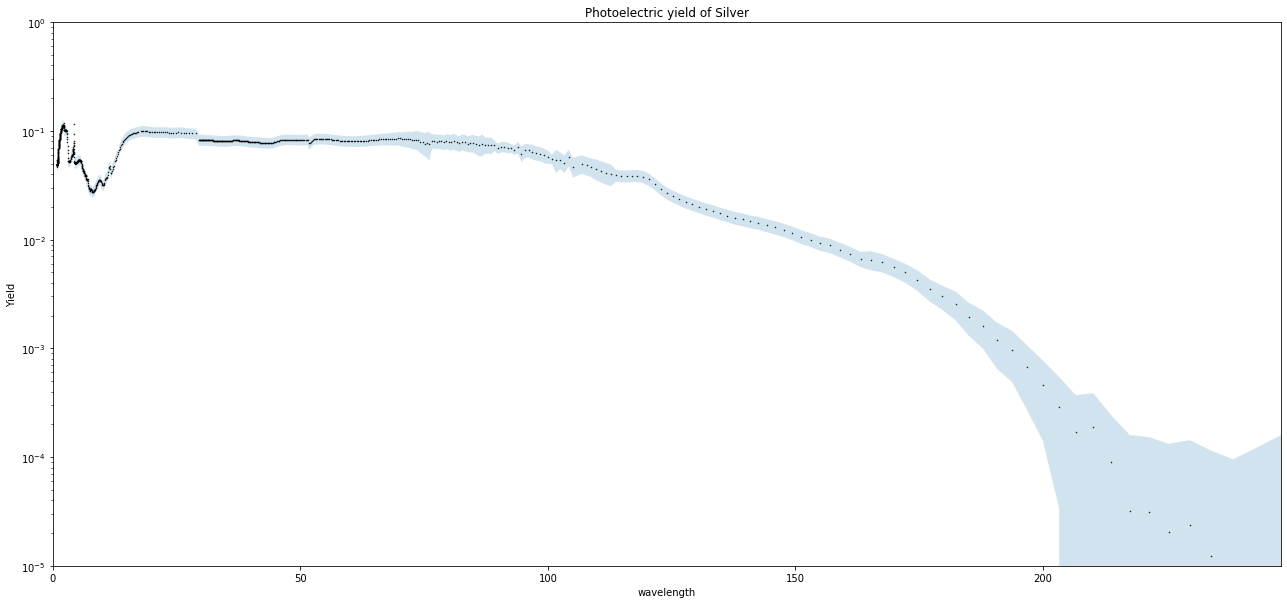

In [412]:
[Ag_full_E, Ag_full_TEY, Ag_full_TEY_err] = read_text_file('TEY_files/Ag_full_yield.txt')

joinstyle='round'
figure(figsize=(22, 10))
plt.plot(convert_eV_to_nm(Ag_full_E),Ag_full_TEY,'.',color='black',markersize=1)
plt.fill_between(np.array(convert_eV_to_nm(Ag_full_E)), np.array(Ag_full_TEY)+np.array(Ag_full_TEY_err), np.array(Ag_full_TEY)-np.array(Ag_full_TEY_err), alpha=alpha, joinstyle=joinstyle)
plt.yscale('log')
plt.xlim(0,convert_eV_to_nm([5])[0])
plt.ylim(1e-5,1)
plt.ylabel("Yield")
plt.xlabel('wavelength')
plt.title('Photoelectric yield of Silver')

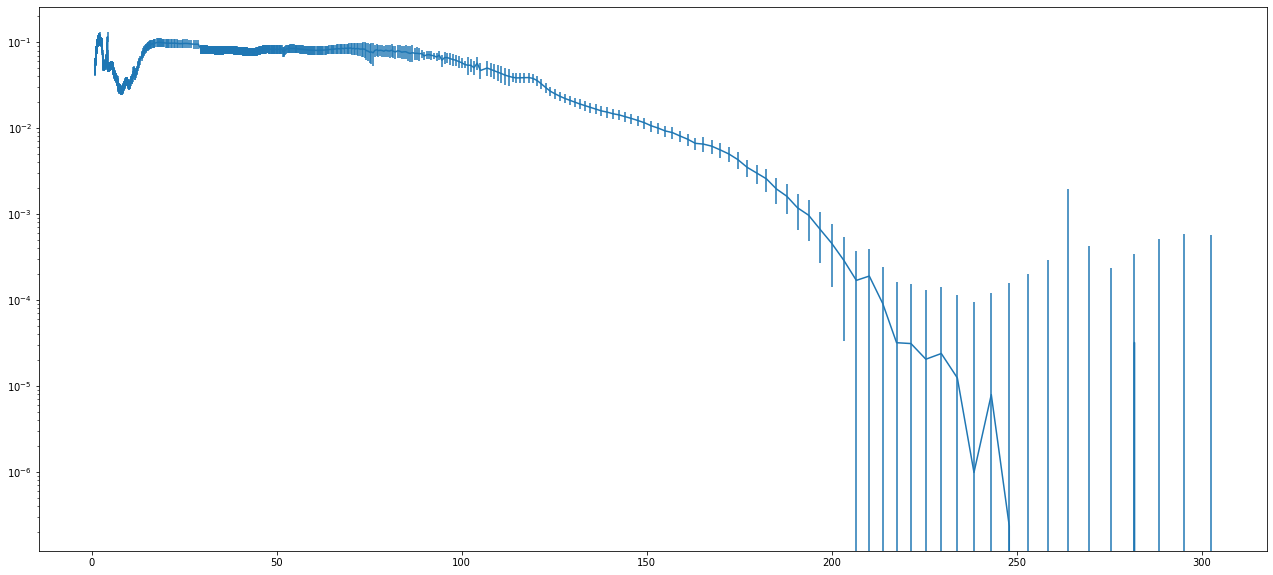

In [413]:
figure(figsize=(22, 10))
plt.errorbar(np.array(convert_eV_to_nm(Ag_full_E)),np.array(Ag_full_TEY),np.array(Ag_full_TEY_err))
plt.yscale('log')

# ITO Radiator

material df:  708 
photodiode df: 708


Text(0.5, 1.0, 'ITO current: August 2022')

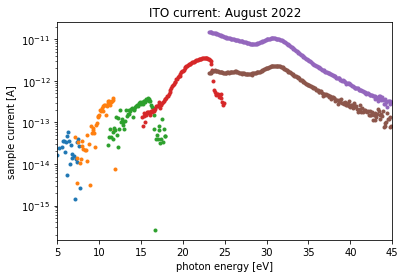

In [352]:
mat_name = 'ITO_low'
mat_file_number = 13
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
ITO_low_sensvals =[[ '200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['20nA' ,'200pA','2uA'],
                    ['20nA' ,'200pA','2uA'],
                    ['20nA' ,'200pA','2uA']]

ITO_low_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_low_df,ITO_low_sensvals,offsets_df)
compute_yield(mat_df=ITO_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=ITO_low_df,pd_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')

for i in range(2,8):
    criterion = ITO_low_df['reg_number'] == i
    pd_df = ITO_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')
plt.xlim(5,45)
plt.title('ITO current: August 2022')
#plt.savefig('plots/ITO_current_Aug22.png', dpi=300)

In [353]:
mat_name = 'ITO_high'
mat_file_number = 7
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves! (in order!)
add_regs_from_files = [0] #number of files from which each respective saturated region shall be substituted from (set 0 if it's supposed to stay empty)
ITO_high_sensvals=[ ['20nA' ,'200pA','2uA'],
                    ['20nA' ,'200pA','2uA'],
                    ['200nA','20nA' ,'20uA'],
                    ['200nA','200pA','2uA'],
                    ['200nA','200pA','2uA'],
                    ['200nA','200pA','2uA']]


ITO_high_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_high_df,ITO_high_sensvals,offsets_df)
compute_yield(mat_df=ITO_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=ITO_high_df,pd_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')


material df:  524 
photodiode df: 524


(0, 247.9953544858527)

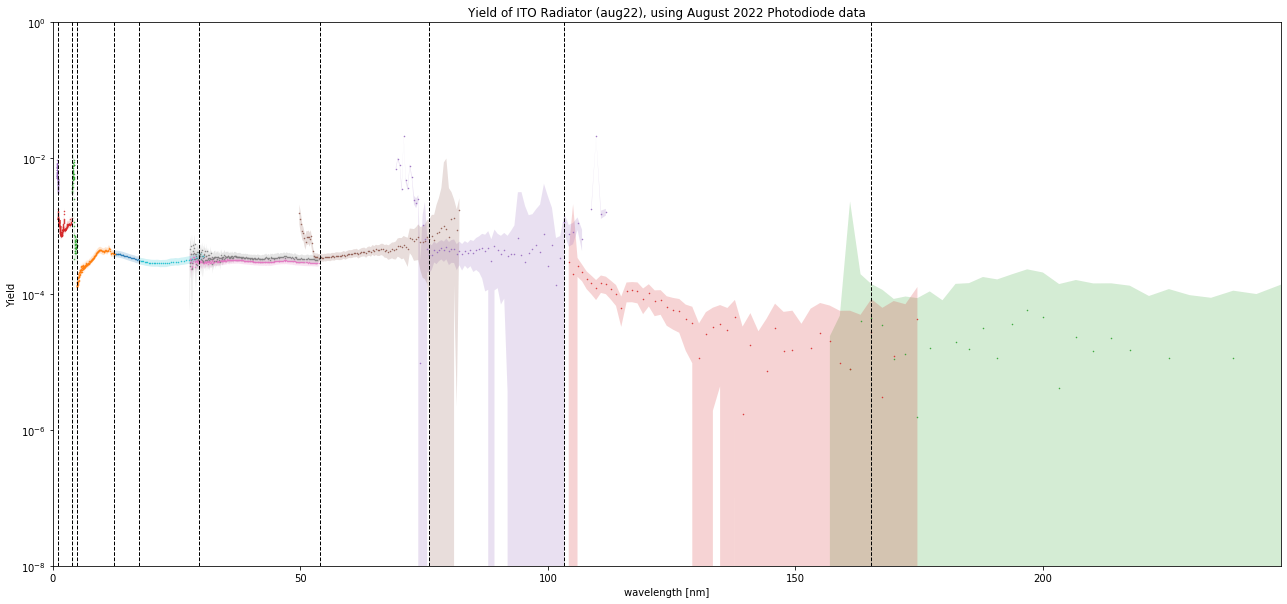

In [380]:
figure(figsize=(22, 10))
lines = ['photon_energy_eV    total_yield    yield_error'] #data will be written into a file in this format
alpha=0.2

for i in range(8):
    criterion = ITO_low_df['reg_number'] == i
    pd_df = ITO_low_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 2 and (phot_E[l] < 7.5):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 7.5 and phot_E[l] < 12):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 12 and phot_E[l] < 16.3):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 16.3 and phot_E[l] < 23):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 23 and phot_E[l] < 42):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

for i in range(8):
    criterion = ITO_high_df['reg_number'] == i
    pd_df = ITO_high_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 1 and (phot_E[l] >= 42 and phot_E[l] < 71):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 2 and (phot_E[l] >= 71 and phot_E[l] < 100):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 100 and phot_E[l] < 258):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 258 and phot_E[l] < 320):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 320 and phot_E[l] < 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

plt.axvline(x=convert_eV_to_nm([7.5])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([12])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([16.3])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([23])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([42])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([71])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([100])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([258])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([320])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([1195])[0],linestyle='--',color='black',linewidth=1)

with open('TEY_files/ITO_aug22_full_yield.txt', 'w') as f:
    f.write('\n'.join(lines))

plt.yscale('log')
plt.ylim(1e-8,1)
plt.xlabel('wavelength [nm]')
plt.ylabel('Yield')
plt.title('Yield of ITO Radiator (aug22), using August 2022 Photodiode data')
#plt.savefig('plots/ITO_aug22_test_Aug22_PD.png', dpi=300)
plt.xlim(0,convert_eV_to_nm([5])[0])

Text(0.5, 1.0, 'Photoelectric yield of ITO Radiator (aug22)')

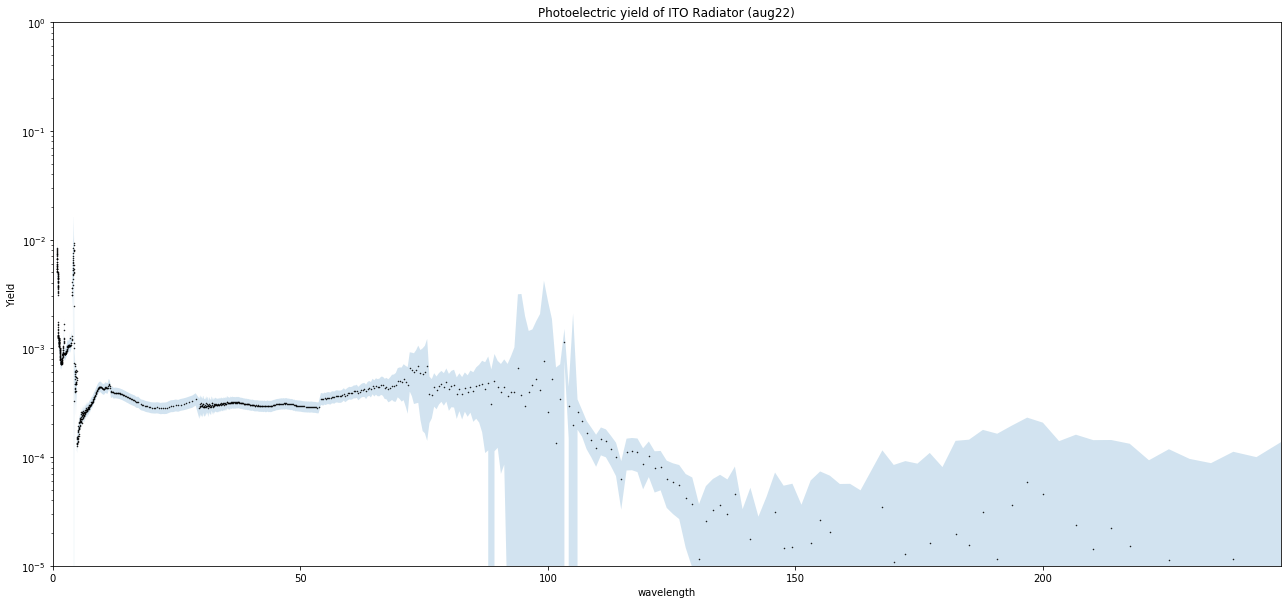

In [381]:
[ITO_aug22_full_E, ITO_aug22_full_TEY, ITO_aug22_full_TEY_err] = read_text_file('TEY_files/ITO_aug22_full_yield.txt')

joinstyle='round'
figure(figsize=(22, 10))
plt.plot(convert_eV_to_nm(ITO_aug22_full_E),ITO_aug22_full_TEY,'.',color='black',markersize=1)
plt.fill_between(np.array(convert_eV_to_nm(ITO_aug22_full_E)), np.array(ITO_aug22_full_TEY)+np.array(ITO_aug22_full_TEY_err), np.array(ITO_aug22_full_TEY)-np.array(ITO_aug22_full_TEY_err), alpha=alpha, joinstyle=joinstyle)
plt.yscale('log')
plt.xlim(0,convert_eV_to_nm([5])[0])
plt.ylim(1e-5,1)
plt.ylabel("Yield")
plt.xlabel('wavelength')
plt.title('Photoelectric yield of ITO Radiator (aug22)')

# ITO MLI

material df:  708 
photodiode df: 708


Text(0.5, 1.0, 'ITO-MLI current: August 2022')

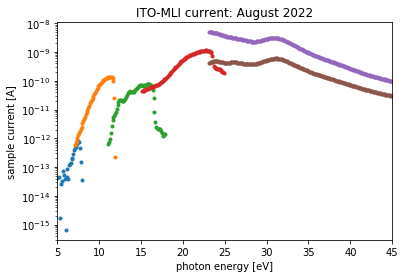

In [394]:
mat_name = 'ITO_MLI_low'
mat_file_number = 37
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
ITO_MLI_low_sensvals =[[ '200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['20nA' ,'20nA','2uA'],
                    ['20nA' ,'20nA','2uA'],
                    ['20nA' ,'20nA','2uA']]

ITO_MLI_low_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_MLI_low_df,ITO_MLI_low_sensvals,offsets_df)
compute_yield(mat_df=ITO_MLI_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=ITO_MLI_low_df,pd_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')

for i in range(2,8):
    criterion = ITO_MLI_low_df['reg_number'] == i
    pd_df = ITO_MLI_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')
plt.xlim(5,45)
plt.title('ITO-MLI current: August 2022')
#plt.savefig('plots/ITO-MLI_current_Aug22.png', dpi=300)

In [395]:
mat_name = 'ITO_MLI_high'
mat_file_number = 35
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves! (in order!)
add_regs_from_files = [0] #number of files from which each respective saturated region shall be substituted from (set 0 if it's supposed to stay empty)
ITO_MLI_high_sensvals=[ ['20nA' ,'20nA','2uA'],
                    ['20nA' ,'20nA','2uA'],
                    ['200nA','200nA' ,'20uA'],
                    ['200nA','200pA','2uA'],
                    ['200nA','20nA','2uA'],
                    ['200nA','200pA','2uA']]


ITO_MLI_high_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_MLI_high_df,ITO_MLI_high_sensvals,offsets_df)
compute_yield(mat_df=ITO_MLI_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=ITO_MLI_high_df,pd_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')


material df:  524 
photodiode df: 524


(0, 247.9953544858527)

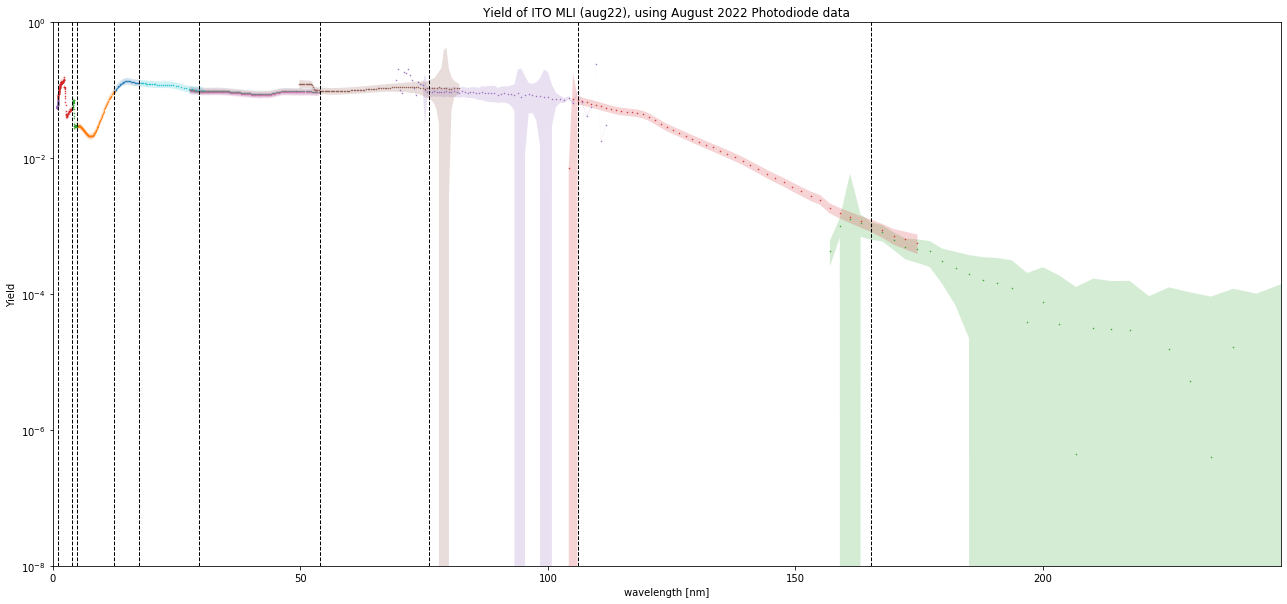

In [396]:
figure(figsize=(22, 10))
lines = ['photon_energy_eV    total_yield    yield_error'] #data will be written into a file in this format
alpha=0.2

for i in range(8):
    criterion = ITO_MLI_low_df['reg_number'] == i
    pd_df = ITO_MLI_low_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 2 and (phot_E[l] < 7.5):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 7.5 and phot_E[l] < 11.7):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 11.7 and phot_E[l] < 16.3):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 16.3 and phot_E[l] < 23):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 23 and phot_E[l] < 42):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

for i in range(8):
    criterion = ITO_MLI_high_df['reg_number'] == i
    pd_df = ITO_MLI_high_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 1 and (phot_E[l] >= 42 and phot_E[l] < 71):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 2 and (phot_E[l] >= 71 and phot_E[l] < 100):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 100 and phot_E[l] < 258):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 258 and phot_E[l] < 320):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 320 and phot_E[l] < 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

plt.axvline(x=convert_eV_to_nm([7.5])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([11.7])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([16.3])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([23])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([42])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([71])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([100])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([258])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([320])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([1195])[0],linestyle='--',color='black',linewidth=1)

with open('TEY_files/ITO_MLI_aug22_full_yield.txt', 'w') as f:
    f.write('\n'.join(lines))

plt.yscale('log')
plt.ylim(1e-8,1)
plt.xlabel('wavelength [nm]')
plt.ylabel('Yield')
plt.title('Yield of ITO MLI (aug22), using August 2022 Photodiode data')
#plt.savefig('plots/ITO_MLI_aug22_test_Aug22_PD.png', dpi=300)
plt.xlim(0,convert_eV_to_nm([5])[0])

Text(0.5, 1.0, 'Photoelectric yield of ITO MLI (aug22)')

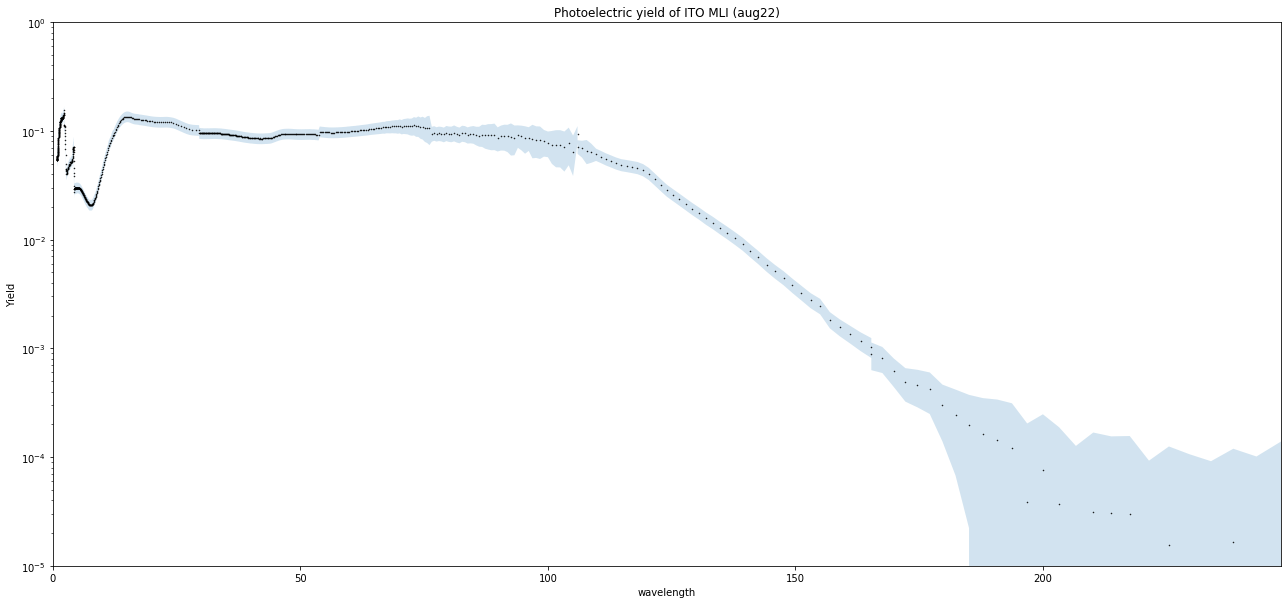

In [425]:
[ITO_MLI_aug22_full_E, ITO_MLI_aug22_full_TEY, ITO_MLI_aug22_full_TEY_err] = read_text_file('TEY_files/ITO_MLI_aug22_full_yield.txt')

joinstyle='round'
figure(figsize=(22, 10))
plt.plot(convert_eV_to_nm(ITO_MLI_aug22_full_E),ITO_MLI_aug22_full_TEY,'.',color='black',markersize=1)
plt.fill_between(np.array(convert_eV_to_nm(ITO_MLI_aug22_full_E)), np.array(ITO_MLI_aug22_full_TEY)+np.array(ITO_MLI_aug22_full_TEY_err), np.array(ITO_MLI_aug22_full_TEY)-np.array(ITO_MLI_aug22_full_TEY_err), alpha=alpha, joinstyle=joinstyle)
plt.yscale('log')
plt.xlim(0,convert_eV_to_nm([5])[0])
plt.ylim(1e-5,1)
plt.ylabel("Yield")
plt.xlabel('wavelength')
plt.title('Photoelectric yield of ITO MLI (aug22)')

# Titanium rods

material df:  708 
photodiode df: 708


Text(0.5, 1.0, 'Ti current: August 2022')

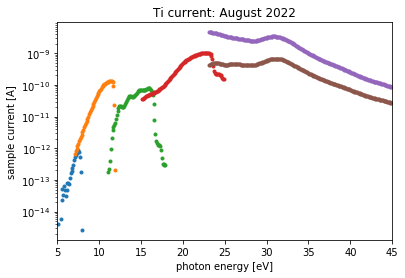

In [359]:
mat_name = 'Ti_low'
mat_file_number = 39
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
Ti_low_sensvals =[[ '200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['20nA' ,'20nA','2uA'],
                        ['20nA' ,'20nA','2uA'],
                        ['20nA' ,'20nA','2uA']]

Ti_low_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Ti_low_df,Ti_low_sensvals,offsets_df)
compute_yield(mat_df=Ti_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=Ti_low_df,pd_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')

for i in range(2,8):
    criterion = Ti_low_df['reg_number'] == i
    pd_df = Ti_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')
plt.xlim(5,45)
plt.title('Ti current: August 2022')
#plt.savefig('plots/Ti_current_Aug22.png', dpi=300)

In [360]:
mat_name = 'Ti_high'
mat_file_number = 32
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves! (in order!)
add_regs_from_files = [0] #number of files from which each respective saturated region shall be substituted from (set 0 if it's supposed to stay empty)
Ti_high_sensvals=[['20nA' ,'20nA','2uA'],
                  ['20nA' ,'200nA','2uA'],
                  ['200nA','200nA' ,'20uA'],
                  ['200nA','200pA','2uA'],
                  ['200nA','20nA','2uA'],
                  ['200nA','200pA','2uA']]


Ti_high_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Ti_high_df,ITO_MLI_high_sensvals,offsets_df)
compute_yield(mat_df=Ti_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=Ti_high_df,pd_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')


material df:  524 
photodiode df: 524


(0, 247.9953544858527)

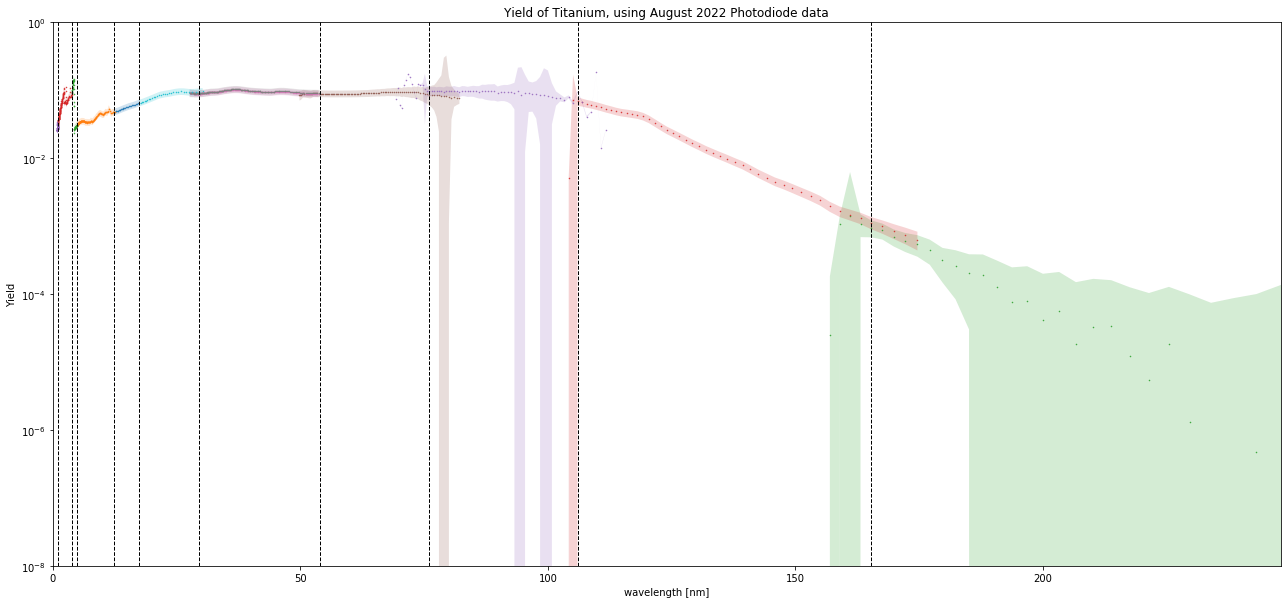

In [372]:
figure(figsize=(22, 10))
lines = ['photon_energy_eV    total_yield    yield_error'] #data will be written into a file in this format
alpha=0.2

for i in range(8):
    criterion = Ti_low_df['reg_number'] == i
    pd_df = Ti_low_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 2 and (phot_E[l] < 7.5):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 7.5 and phot_E[l] < 11.7):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 11.7 and phot_E[l] < 16.3):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 16.3 and phot_E[l] < 23):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 23 and phot_E[l] < 42):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

for i in range(8):
    criterion = Ti_high_df['reg_number'] == i
    pd_df = Ti_high_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 1 and (phot_E[l] >= 42 and phot_E[l] < 71):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 2 and (phot_E[l] >= 71 and phot_E[l] < 100):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 100 and phot_E[l] < 258):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 258 and phot_E[l] < 320):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 320 and phot_E[l] < 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

plt.axvline(x=convert_eV_to_nm([7.5])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([11.7])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([16.3])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([23])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([42])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([71])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([100])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([258])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([320])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([1195])[0],linestyle='--',color='black',linewidth=1)

with open('TEY_files/Ti_full_yield.txt', 'w') as f:
    f.write('\n'.join(lines))

plt.yscale('log')
plt.ylim(1e-8,1)
plt.xlabel('wavelength [nm]')
plt.ylabel('Yield')
plt.title('Yield of Titanium, using August 2022 Photodiode data')
#plt.savefig('plots/Ti_test_Aug22_PD.png', dpi=300)
plt.xlim(0,convert_eV_to_nm([5])[0])

Text(0.5, 1.0, 'Photoelectric yield of Titanium rods')

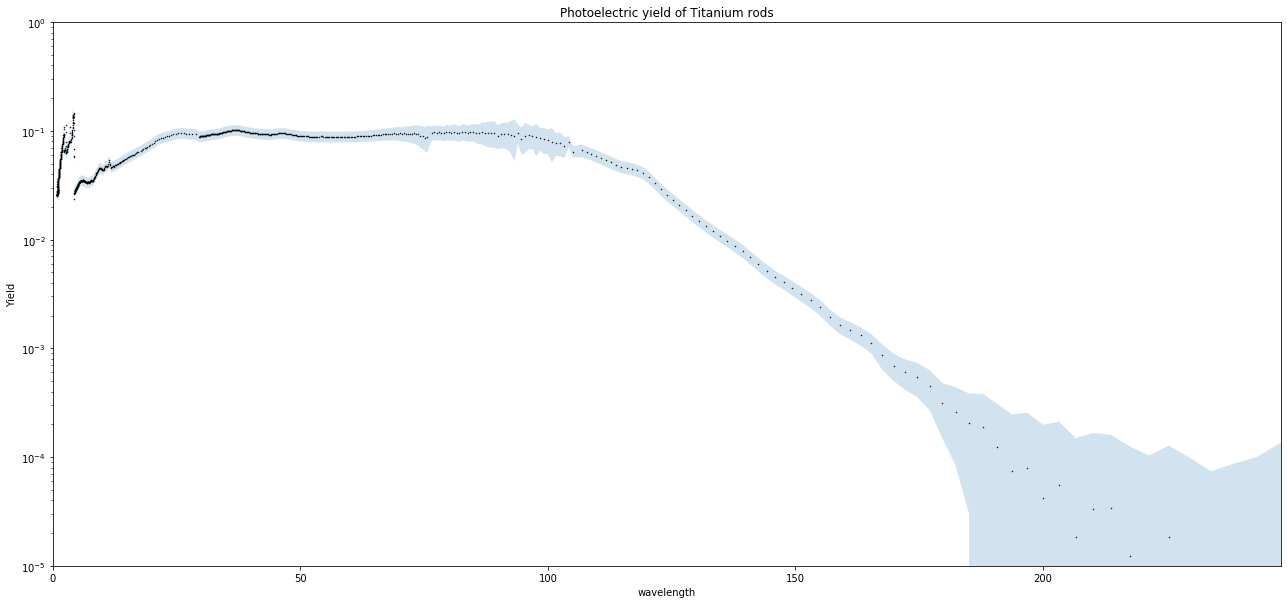

In [429]:
[Ti_full_E, Ti_full_TEY, Ti_full_TEY_err] = read_text_file('TEY_files/Ti_full_yield.txt')

joinstyle='round'
figure(figsize=(22, 10))
plt.plot(convert_eV_to_nm(Ti_full_E),Ti_full_TEY,'.',color='black',markersize=1)
plt.fill_between(np.array(convert_eV_to_nm(Ti_full_E)), np.array(Ti_full_TEY)+np.array(Ti_full_TEY_err), np.array(Ti_full_TEY)-np.array(Ti_full_TEY_err), alpha=alpha, joinstyle=joinstyle)
plt.yscale('log')
plt.xlim(0,convert_eV_to_nm([5])[0])
plt.ylim(1e-5,1)
plt.ylabel("Yield")
plt.xlabel('wavelength')
plt.title('Photoelectric yield of Titanium rods')

# ITO 2

material df:  708 
photodiode df: 708


Text(0.5, 1.0, 'ITO2 current: August 2022')

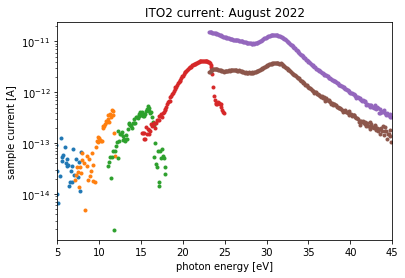

In [362]:
mat_name = 'ITO2_low'
mat_file_number = 44
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
ITO2_low_sensvals =[['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['200pA','200pA','2uA'],
                    ['20nA' ,'200pA','2uA'],
                    ['20nA' ,'200pA','2uA'],
                    ['20nA' ,'200pA','2uA']]

ITO2_low_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO2_low_df,ITO2_low_sensvals,offsets_df)
compute_yield(mat_df=ITO2_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=ITO2_low_df,pd_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')

for i in range(2,8):
    criterion = ITO2_low_df['reg_number'] == i
    pd_df = ITO2_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')
plt.xlim(5,45)
plt.title('ITO2 current: August 2022')
#plt.savefig('plots/ITO2_current_Aug22.png', dpi=300)

In [363]:
mat_name = 'ITO2_high'
mat_file_number = 43
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves! (in order!)
add_regs_from_files = [0] #number of files from which each respective saturated region shall be substituted from (set 0 if it's supposed to stay empty)
ITO2_high_sensvals=[['20nA' ,'200pA','2uA'],
                    ['20nA' ,'200pA','2uA'],
                    ['200nA','20nA' ,'20uA'],
                    ['200nA','200pA','2uA'],
                    ['200nA','200pA','2uA'],
                    ['200nA','200pA','2uA']]


ITO2_high_df = concate_regions_aug22(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO2_high_df,ITO2_high_sensvals,offsets_df)
compute_yield(mat_df=ITO2_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
yield_error(mat_df=ITO2_high_df,pd_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march')


material df:  524 
photodiode df: 524


(0, 247.9953544858527)

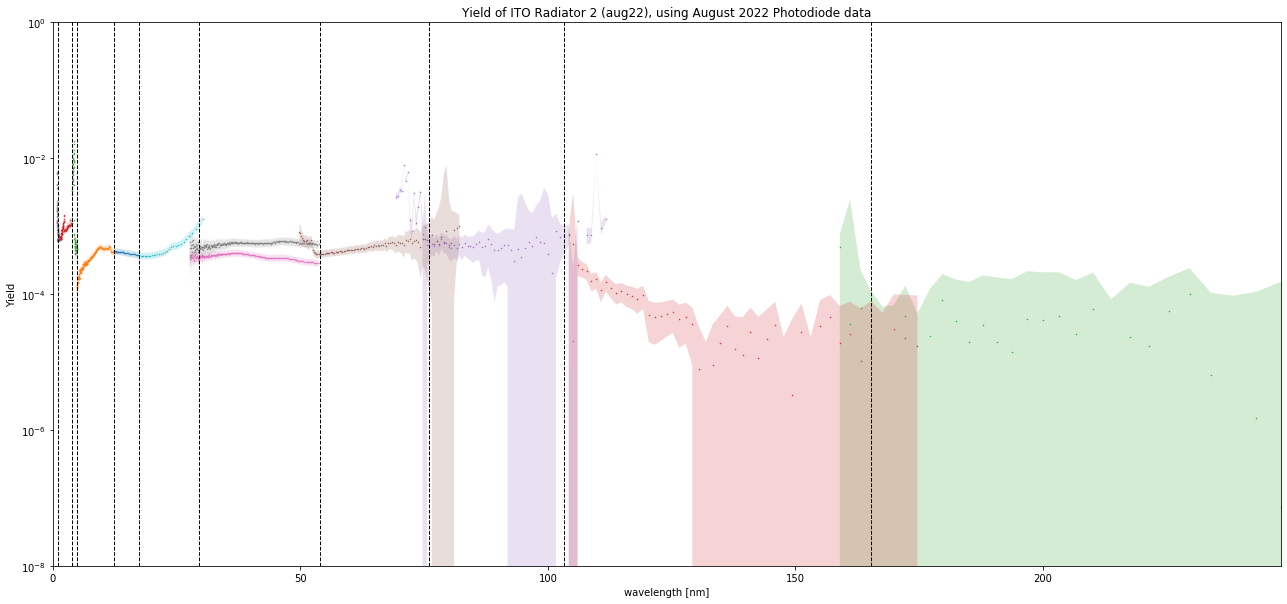

In [382]:
figure(figsize=(22, 10))
lines = ['photon_energy_eV    total_yield    yield_error'] #data will be written into a file in this format
alpha=0.2

for i in range(8):
    criterion = ITO2_low_df['reg_number'] == i
    pd_df = ITO2_low_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 2 and (phot_E[l] < 7.5):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 7.5 and phot_E[l] < 12):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 12 and phot_E[l] < 16.3):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 16.3 and phot_E[l] < 23):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 23 and phot_E[l] < 42):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

for i in range(8):
    criterion = ITO2_high_df['reg_number'] == i
    pd_df = ITO2_high_df.loc[criterion]
    phot_E = pd_df['phot_E'].tolist()
    TEY = pd_df['Yield'].tolist()
    TEY_err = pd_df['yield_err'].tolist()
    plt.plot(convert_eV_to_nm(phot_E),np.array(TEY),'.',markersize=1)
    plt.fill_between(np.array(convert_eV_to_nm(phot_E)), np.array(TEY)-np.array(TEY_err), np.array(TEY)+np.array(TEY_err), alpha=alpha)

    for l in range(len(phot_E)):
        if i == 1 and (phot_E[l] >= 42 and phot_E[l] < 71):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 2 and (phot_E[l] >= 71 and phot_E[l] < 100):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 3 and (phot_E[l] >= 100 and phot_E[l] < 258):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 4 and (phot_E[l] >= 258 and phot_E[l] < 320):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 5 and (phot_E[l] >= 320 and phot_E[l] < 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)
        elif i == 6 and (phot_E[l] >= 1195):
            line = str(phot_E[l]) + ' ' + str(TEY[l]) + ' ' + str(TEY_err[l])
            lines.append(line)

plt.axvline(x=convert_eV_to_nm([7.5])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([12])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([16.3])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([23])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([42])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([71])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([100])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([258])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([320])[0],linestyle='--',color='black',linewidth=1)
plt.axvline(x=convert_eV_to_nm([1195])[0],linestyle='--',color='black',linewidth=1)

with open('TEY_files/ITO2_aug22_full_yield.txt', 'w') as f:
    f.write('\n'.join(lines))

plt.yscale('log')
plt.ylim(1e-8,1)
plt.xlabel('wavelength [nm]')
plt.ylabel('Yield')
plt.title('Yield of ITO Radiator 2 (aug22), using August 2022 Photodiode data')
#plt.savefig('plots/ITO2_aug22_test_Aug22_PD.png', dpi=300)
plt.xlim(0,convert_eV_to_nm([5])[0])

Text(0.5, 1.0, 'Photoelectric yield of ITO Radiator 2 (aug22)')

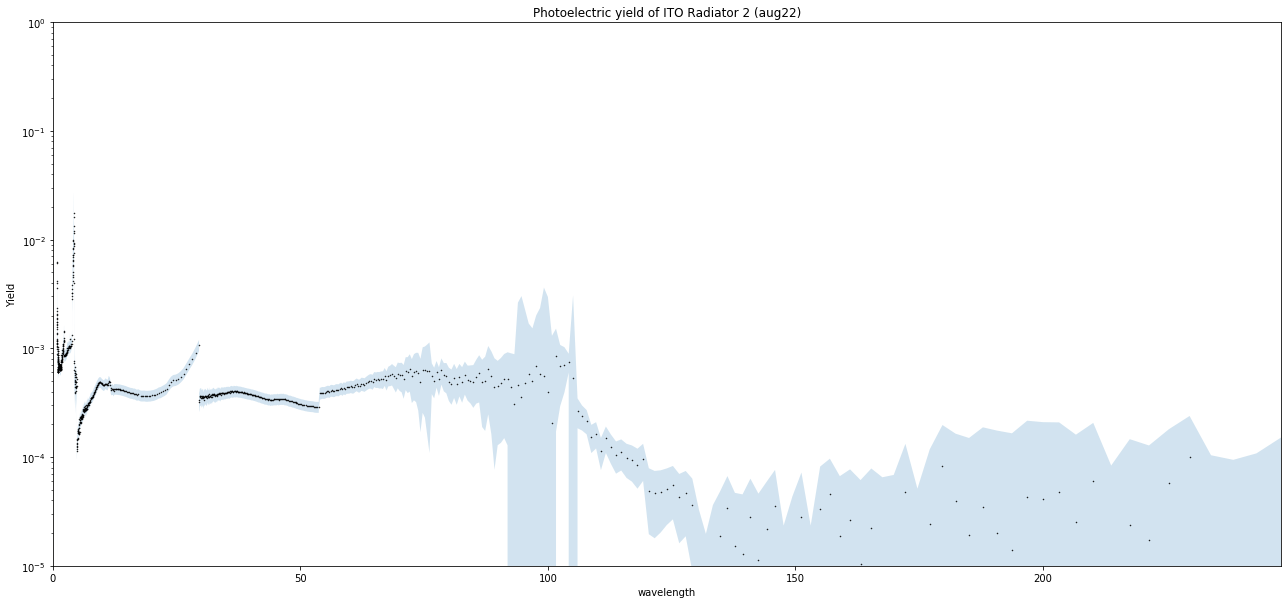

In [385]:
[ITO2_aug22_full_E, ITO2_aug22_full_TEY, ITO2_aug22_full_TEY_err] = read_text_file('TEY_files/ITO2_aug22_full_yield.txt')

joinstyle='round'
figure(figsize=(22, 10))
plt.plot(convert_eV_to_nm(ITO2_aug22_full_E),ITO2_aug22_full_TEY,'.',color='black',markersize=1)
plt.fill_between(np.array(convert_eV_to_nm(ITO2_aug22_full_E)), np.array(ITO2_aug22_full_TEY)+np.array(ITO2_aug22_full_TEY_err), np.array(ITO2_aug22_full_TEY)-np.array(ITO2_aug22_full_TEY_err), alpha=alpha, joinstyle=joinstyle)
plt.yscale('log')
plt.xlim(0,convert_eV_to_nm([5])[0])
plt.ylim(1e-5,1)
plt.ylabel("Yield")
plt.xlabel('wavelength')
plt.title('Photoelectric yield of ITO Radiator 2 (aug22)')